In [1]:
import numpy as np
import scipy.special as sspec
import scipy.stats as ss
import scipy.linalg as sl
import multiprocessing as mp
import time

%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
def drift(x):
    out = -x**3 + 4*x
    return out

g = 0.1

In [19]:
# set up grids of s and u values
smax = 2000
sres = 4000
ds = 2*smax/sres
svec = -smax + ds*np.arange(sres)
uvec = np.copy(svec)

# set up integrand
alpha = 1.0
beta = ds**2/5
def f(x,s,h):
    return np.exp(1j*s*h*drift(x) - h*(np.abs(s)*g)**alpha - beta*(x**2)/4) 

In [20]:
ds

1.0

In [21]:
# set the value of h
thish = 0.01

# set the initial condition parameters
mymean = 0.0
mysd = 0.1

# set the initial pdf
def initp(x):
    return ss.norm.pdf(x,loc=mymean,scale=mysd)

# set the initial charfun
def initpcf(s):
    return np.exp(1j*mymean*s - 0.5*(mysd*s)**2)

In [22]:
# set up x grid for integration
Nx = 512
L = 16
dx = L/Nx
xvec = np.arange(-L/2,L/2,dx)

In [23]:
# initialize kernel matrix
# kernelmat = np.zeros((sres,sres),dtype='D')

In [24]:
drift(L/2)

-480.0

In [25]:
def computeonerow(i):
    
    outrow = np.zeros(sres,dtype='D')
    s = svec[i]
    
    # compute shifted coordinate
    k = s - uvec
        
    # compute integral for all values of u
    for j in range(Nx):
        
        # compute quadrature points
        x1 = xvec[j]
        x2 = x1 + dx
        
        # product quadrature rule
        m0 = np.divide((np.exp(1j*k*x2) - np.exp(1j*k*x1)), 1j*k, 
                       out=dx*np.ones_like(k,dtype='D'), where=k!=0)
        m1 = np.divide((x2*np.exp(1j*k*x2) - x1*np.exp(1j*k*x1)), 1j*k, 
                       out=0.5*(x2**2 - x1**2)*np.ones_like(k,dtype='D'), where=k!=0)
        m1 += np.divide((np.exp(1j*k*x2) - np.exp(1j*k*x1)), k**2, 
                        out=np.zeros_like(k,dtype='D'), where=k!=0)
        
        # compute quadrature weights
        w1 = -(m1 - x2*m0)/dx
        w2 = (m1 - x1*m0)/dx
        
        # compute integral over [x1, x2]
        outrow += w1*f(x1,s,thish) + w2*f(x2,s,thish)
    
    outrow /= (2.0*np.pi)
    
    # add asymptotic correction
    asymp = -(k**2)/beta - thish*(np.abs(s*g)**alpha) - ((beta*L - 4j*k)/(4*np.sqrt(beta)))**2
    asymp2 = np.log(sspec.wofz(1j*(beta*L - 4j*k)/(4*np.sqrt(beta))))
    asymp3 = 2*np.sqrt(beta*np.pi)
    totalasymp = 2.0*np.real(np.exp(asymp + asymp2))/asymp3
    outrow += totalasymp
    
    return outrow


In [26]:
# print(sspec.wofz(1j*(beta*L - 4j*(-uvec))/(4*np.sqrt(beta))))
# print(np.exp( -uvec**2/beta ))
# computeonerow(100)

In [27]:
curtime = time.time()
pool = mp.Pool(processes=2)
kernelmat = np.vstack(pool.map(computeonerow, range(sres)))
timetaken = time.time() - curtime
print(timetaken)
pool.close()


2068.4639868736267


In [28]:
print(sl.norm(kernelmat,np.inf))

7.953750559307647


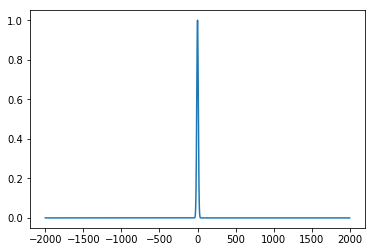

In [29]:
plt.plot(svec, np.abs(initpcf(svec)))

In [30]:
colloc = np.zeros((sres,sres))
for i in range(sres):
    for j in range(sres):
        colloc[i,j] = np.exp(-(i*ds - j*ds)**2/beta)

1.26156541629 1.0
1.26156549692 1.0
1.26156557894 1.0
1.2615656554 1.0
1.26156572365 1.0
1.26156578131 1.0
1.26156582964 1.0
1.26156586949 1.0
1.26156590165 1.0
1.2615659277 1.0
1.26156594855 1.0
1.26156596496 1.0
1.26156597776 1.0
1.26156598777 1.0
1.26156599559 1.0
1.26156600166 1.0
1.26156600639 1.0
1.26156601004 1.0
1.26156601285 1.0
1.261566015 1.0
1.26156601666 1.0
1.26156601793 1.0
1.2615660189 1.0
1.26156601965 1.0
1.26156602021 1.0
1.26156602065 1.0
1.26156602098 1.0
1.26156602123 1.0
1.26156602141 1.0
1.26156602156 1.0
1.26156602167 1.0
1.26156602175 1.0
1.26156602181 1.0
1.26156602186 1.0
1.2615660219 1.0
1.26156602192 1.0
1.26156602194 1.0
1.26156602196 1.0
1.26156602197 1.0
1.26156602198 1.0
1.26156602199 1.0
1.26156602199 1.0
1.261566022 1.0
1.261566022 1.0
1.261566022 1.0
1.261566022 1.0
1.261566022 1.0
1.261566022 1.0
1.26156602201 1.0
1.26156602201 1.0


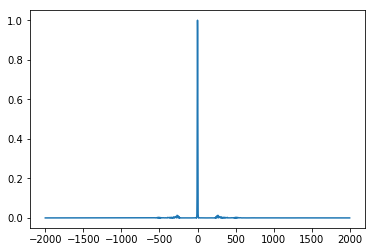

In [31]:
# cf = initpcf(svec)
coef = np.zeros(sres)
coef[sres//2] = 1
numsteps = 50
for i in range(numsteps):
    cf = np.real(np.dot(kernelmat,coef))
    oldmax = cf[sres//2]
    cf /= np.max(cf)
    print(oldmax, cf[sres//2])
    coef = sl.solve(colloc, cf)
    
plt.plot(svec, np.abs(cf))

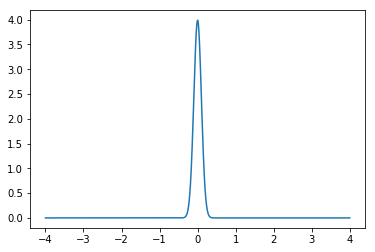

In [32]:
# set up x grid for plotting
Lplot = 8
dxplot = 1/(sres*ds)
xplot = np.arange(-Lplot/2,Lplot/2,dxplot)
Nxplot = xplot.shape[0]

# initial PDF
plt.plot(xplot, initp(xplot))

In [33]:
# Fourier matrix
fouriermat = np.zeros((Nxplot,sres),dtype='D')
for i in range(Nxplot):
    fouriermat[i,] = np.exp(-1j*uvec*xplot[i])/(2.0*np.pi)


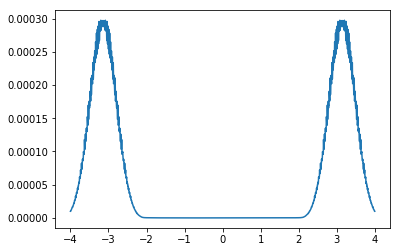

In [34]:
# PDF at next time step
plt.plot(xplot, np.real(dxplot*np.dot(fouriermat,cf)))